In [1]:
from langchain_community.tools import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages
from langchain_mistralai import ChatMistralAI
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from uuid import uuid4
from typing import TypedDict,Annotated
from langsmith import traceable
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
api_keys=[os.getenv('google'),os.getenv('mistral_ai')]

In [3]:
memory=InMemorySaver()

In [4]:
tool=TavilySearchResults(max_results=2,include_answer=True)
tools=[tool]

/var/folders/kh/4f4bk94j1d36fl9w_7g2nhdm0000gn/T/ipykernel_42683/3676676516.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool=TavilySearchResults(max_results=2,include_answer=True)


In [5]:
google=ChatGoogleGenerativeAI(api_key=api_keys[0],model='gemini-2.5-flash')

In [6]:
llm_with_tool=google.bind_tools(tools=tool)

convert_to_genai_function_declarations expects a Sequence and not a single tool.


In [7]:
class LLM_TOOL(TypedDict):
    message: Annotated[list[BaseMessage],add_messages]


In [8]:
graph=StateGraph(LLM_TOOL)

In [9]:
def chatbot(state:LLM_TOOL)->LLM_TOOL['message']:
    return {'message':[llm_with_tool.invoke(state['message'])]}

def router(state:LLM_TOOL):
    last_message=state['message'][-1]
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return 'tool'
    return 'end'

In [10]:
tool_node=ToolNode(tools=tools,messages_key='message')

In [11]:
graph.add_node('chatbot',chatbot)
graph.add_node('tool',tool_node)
graph.set_entry_point('chatbot')

graph.add_conditional_edges('chatbot',router,{'tool':'tool','end':END})
graph.add_edge('tool','chatbot')


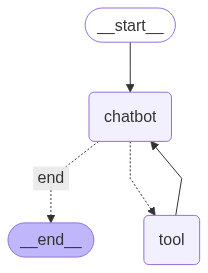

In [12]:
workflow=graph.compile(checkpointer=memory)
workflow

In [15]:
while True:
    input_user=input('user:')
    config={'configurable':{'thread_id':'thread-1'}}
    if any( i in input_user for i in ['exit','quit','bye']):
        break
    else:
        response=workflow.invoke({'message':[HumanMessage(content=input_user)]},config=config)
        print('AI',response['message'][-1].content)

AI Hello! How can I help you today?
AI Nice to meet you, Divy! How can I assist you today?
AI Your name is Divy.
AI As an AI, I don't have feelings or a physical state, so I can't be "good" or "bad" in the way a human can. I'm here and ready to help you! How can I assist you today, Divy?
AI For a 20-year-old student aiming to become a millionaire, a top skill to develop is **copywriting and content strategy**.

This involves creating compelling written and visual content that can be used for marketing, sales, and building an online presence. In today's digital world, businesses and individuals constantly need engaging content, making this a highly valuable and in-demand skill.
AI That's a very insightful question, and it's true that AI is making significant strides in content generation. However, here's why copywriting, even with AI, remains a crucial and high-income skill:

1.  **Strategic Nuance and Human Empathy:** AI can generate text, but it often lacks the deep understanding of h